# CDK2: Model Selection - y values shuffled
### Validation Method

In [97]:
import pandas as pd
import numpy as np
import glob, sys, os
sys.path.append('..')

In [98]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk', font_scale=0.8)

In [99]:
file_name = './df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
# Extract activity column
y_true_merged = X_merged_dksc['activity']
# Drop column from merged_dkksc
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape
y_true_merged.loc['DEKOIS'].sum()

40

## Scaffold Splitting

In [100]:
#*************************************************
# Functions to compute stratify scaffold splitting
#*************************************************
sys.path.append('../2_Docking_analysis/')
from scaffold_splitter import train_test_scaffold_split

In [101]:
# Compute or load the dataframe containing the Generic Murcko Scaffolds
file = '../2_Docking_analysis/df_COCRYS_CSAR_DUD_DEKOIS_Murcko_Scaffolds_SMILES.obj'

df_scff_murcko = pd.read_pickle(file)
df_scff_murcko.shape

(3466, 3)

### Helper Functions

In [102]:
%run 4_Helper_Functions_Model_Selection_Grid_Search.ipynb

#  Hyperparameter Tunning: Grid Search

In [103]:
def randomize_y_labels(y_target, random_chi=0.1):
    '''Función para distribuir de forma aleatoria una fracción 
    chi del vector de etiquetas, de forma estratificada'''
    
    # Make a copy of the original vector
    y_copy = y.copy()
    
    # Get the number of actives inside the y_target vector
    n_actives = y_target.sum()
    random_size = np.floor(random_chi * n_actives)
    # Initialize the counters
    act_count = random_size
    inact_count = random_size
    
    # Create the randomized list of idexes
    idx_shuffled = np.random.choice(range(len(y)), len(y), replace=False)
    # iterate over idx_shuffled until act and inact counters == 0
    for l in idx_shuffled:
        if act_count > 0:
            if y_copy[l] == 1: # Is active, then change it to inactive
                y_copy[l] = 0
                act_count = act_count - 1
                continue
            if inact_count > 0: # If is inactive, change it to active
                y_copy[l] = 1
                inact_count = inact_count - 1
                continue
        else:
            break
    return(y_copy)
    

***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    Merged libraries: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DEKOIS, DUD and COCRYS are  treated as one unique library
#### Target values (y) will be shuffled

In [106]:
# Train and test over 
X = X_merged_dksc
# ***** Permutate y values *****
y = y_true_merged#.sample(frac=1, replace=False)

library = 'Merged'
scaffold_series = df_scff_murcko['scff_generic']

# Create an empty dictionary to save results

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [9]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150} 
        estimator = LogisticRegression(**hyperparams)
        
        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='random', test_size=0.25, 
                     scaffold_series=None, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 19min 21s, sys: 40.6 s, total: 20min 2s
Wall time: 54min 56s


In [10]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1.0, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150}
        estimator = LogisticRegression(**hyperparams)

        # SCAFFOLD Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='scaffold', test_size=0.25, 
                     scaffold_series=scaffold_series, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 22min 16s, sys: 40.2 s, total: 22min 56s
Wall time: 59min 35s


<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: X Gradient Boosting </h3>
<b>Merged Libraries</b>

In [11]:
%%time

from xgboost import XGBClassifier

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'XGB_tree'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        estimator = XGBClassifier()
        hyperparams = {'subsample': 0.5, 
                       'n_estimators': 200, 'max_depth': 10,
                       'learning_rate': 0.1, 'gamma': 1, 
                       'colsample_bytree': 0.5, 'alpha': 0.5}

        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='random', test_size=0.25, 
                     scaffold_series=None, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 44min 14s, sys: 14.8 s, total: 44min 29s
Wall time: 22min 35s


In [12]:
%%time

from xgboost import XGBClassifier

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'XGB_tree'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        estimator = XGBClassifier()
        hyperparams = {'subsample': 0.5, 
                       'n_estimators': 200, 'max_depth': 10,
                       'learning_rate': 0.1, 'gamma': 1, 
                       'colsample_bytree': 0.5, 'alpha': 0.5}

        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='scaffold', test_size=0.25, 
                     scaffold_series=scaffold_series, verbose=False) 

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 25min 50s, sys: 3.9 s, total: 25min 54s
Wall time: 18min 55s


<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Radial Basis Function SVM</h3>
<b>Merged Libraries</b>

In [108]:
%%time
from sklearn.svm import SVC
chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)
    
        estimator_name = 'rbfSVC'
        estimator_name = estimator_name + '_chi' + str(chi)
        estimator = SVC(kernel = 'rbf', probability=True)
        hyperparams = {'kernel': 'rbf', 
                       'probability': True, 
                       'C': 10.0, 'gamma': 0.01} 

        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='random', test_size=0.25, 
                     scaffold_series=None, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 11min 59s, sys: 691 ms, total: 12min
Wall time: 26min 29s


In [107]:
%%time
from sklearn.svm import SVC
chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)
    
        estimator_name = 'rbfSVC'
        estimator_name = estimator_name + '_chi' + str(chi)
        estimator = SVC(kernel = 'rbf', probability=True)
        hyperparams = {'kernel': 'rbf', 
                       'probability': True, 
                       'C': 10.0, 'gamma': 0.01} 
    
        # SCAFFOLD Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='scaffold', test_size=0.25, 
                     scaffold_series=scaffold_series, verbose=False)

valor chi: 0
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
valor chi: 0.1
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=N

***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    DEKOIS: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DEKOIS 
#### Target values (y) will be shuffled

In [15]:
library = 'DEKOIS'

# Train and test over DUDU
X = X_merged_dksc.loc[library]
y = y_true_merged.loc[library]
scaffold_series = df_scff_murcko['scff_generic'].loc[library]

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [16]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150} 
        estimator = LogisticRegression(**hyperparams)
        
        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='random', test_size=0.25, 
                     scaffold_series=None, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 5min 28s, sys: 38.4 s, total: 6min 6s
Wall time: 6min 51s


In [17]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1.0, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150}
        estimator = LogisticRegression(**hyperparams)

        # SCAFFOLD Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='scaffold', test_size=0.25, 
                     scaffold_series=scaffold_series, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 5min 16s, sys: 39.7 s, total: 5min 55s
Wall time: 6min 26s


***
<h2 style='background-color: #F9E5AB; padding: 5px;'>
    DUD: Shuffle *y* target values in the train set
</h2>
<div style='background-color: #FE8460; min-height: 5px'></div>

#### DUD 
#### Target values (y) will be shuffled

In [18]:
library = 'DUD'

# Train and test over DUDU
X = X_merged_dksc.loc[library]
y = y_true_merged.loc[library]
scaffold_series = df_scff_murcko['scff_generic'].loc[library]

<h3 style='color: #F84122; padding: 0px;; margin: 0px'>GS: Logistic Regression</h3>
<b>Merged Libraries</b>

In [19]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150} 
        estimator = LogisticRegression(**hyperparams)
        
        # RANDOM Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='random', test_size=0.25, 
                     scaffold_series=None, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 6min 39s, sys: 40.3 s, total: 7min 19s
Wall time: 9min 54s


In [20]:
%%time
from sklearn.linear_model import LogisticRegression

chi_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

for chi in chi_values:
    print('valor chi:', chi)
    for rep in range(10):
        y_rd = randomize_y_labels(y, chi)

        estimator_name = 'LogReg'
        estimator_name = estimator_name + '_chi' + str(chi) + '_rep' + str(rep)
        hyperparams = {'C': 1.0, 
                       'penalty': 'l1', 
                       'solver': 'liblinear', 
                       'max_iter': 150}
        estimator = LogisticRegression(**hyperparams)

        # SCAFFOLD Train test splitting
        split_and_gs(library, library, estimator_name,
                     X, y_rd, estimator, {},
                     splitting='scaffold', test_size=0.25, 
                     scaffold_series=scaffold_series, verbose=False)

valor chi: 0
valor chi: 0.1
valor chi: 0.2
valor chi: 0.3
valor chi: 0.4
valor chi: 0.5
valor chi: 1
CPU times: user 6min 25s, sys: 40.4 s, total: 7min 6s
Wall time: 9min 2s


# Results

In [32]:

row_names = ['Train_set', 'Test_set', 'Model name', 'Split', 
             'N_actives_train', 'N_actives_test', 'N_mols_train', 'Num_mols_test',
            'Mean-CV-ROC', 'ROC-AUC_train', 'ROC-AUC_test', 'best_params',
            'DkS_max_ROC_train',  'DkSc_med_ROC_train', 'DkSc_mean_ROC_train', 
            'DkS_max_ROC_test',  'DkSc_med_ROC_test', 'DkSc_mean_ROC_test'
            ]


y_shuffled_ml_model_selecion = pd.DataFrame(results_dict, index = row_names).T
y_shuffled_ml_model_selecion.to_pickle('df_y_shuffled_ml_model_selecion.pkl')

In [33]:
# y_shuffled_ml_model_selecion

## Analysis

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style=None, font_scale=0.8, palette='Dark2')
import warnings
warnings.filterwarnings("ignore")
y_shuffled_ml_model_selecion = pd.read_pickle('./df_y_shuffled_ml_model_selecion.pkl')

# Create a column to indicate the chi value
df = y_shuffled_ml_model_selecion
df['chi'] =  df['Model name'].str.split('_chi').str[1].str.split('_').str[0]
df['rep'] =  df['Model name'].str.split('_rep').str[1]
df['Model name'] = df['Model name'].str.split('_').str[0]
df.drop(['best_params'], axis=1, inplace=True)
df = df.reset_index(drop=True)
df.set_index(['Train_set', 'Test_set', 'Model name', 'Split', 'chi', 'rep'], inplace=True)
df = df.sort_index(level=1, axis=1)

In [96]:
df

DkS_max_ROC_test  \
Train_set Test_set Model name Split    chi rep                    
Merged    Merged   LogReg     random   0   0           0.664961   
                                           1           0.690896   
                                           2           0.667671   
                                           3           0.692194   
                                           4            0.64023   
...                                                         ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN         0.695249   
                                       0.3 NaN         0.550603   
                                       0.4 NaN         0.507768   
                                       0.5 NaN         0.630618   
                                       1   NaN         0.515686   

                                               DkS_max_ROC_train  \
Train_set Test_set Model name Split    chi rep                     
Merged    Merged   LogReg     random   0   0             0.67526   
                                           1             0.66769   
                                           2            0.679628   
                                           3            0.672335   
                                           4            0.685003   
...                                                          ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN          0.638622   
                                       0.3 NaN          0.678921   
                                       0.4 NaN          0.677455   
                                       0.5 NaN          0.647521   
                                       1   NaN          0.629083   

                                               DkSc_mean_ROC_test  \
Train_set Test_set Model name Split    chi rep                      
Merged    Merged   LogReg     random   0   0             0.605849   
                                           1              0.62964   
                                           2             0.602171   
                                           3             0.621353   
                                           4              0.57043   
...                                                           ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN           0.566116   
                                       0.3 NaN           0.424346   
                                       0.4 NaN           0.359989   
                                       0.5 NaN           0.503124   
                                       1   NaN           0.399366   

                                               DkSc_mean_ROC_train  \
Train_set Test_set Model name Split    chi rep                       
Merged    Merged   LogReg     random   0   0              0.609875   
                                           1              0.602011   
                                           2               0.61146   
                                           3              0.604943   
                                           4              0.622156   
...                                                            ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN            0.523467   
                                       0.3 NaN            0.573958   
                                       0.4 NaN            0.569944   
                                       0.5 NaN            0.559688   
                                       1   NaN            0.542809   

                                               DkSc_med_ROC_test  \
Train_set Test_set Model name Split    chi rep                     
Merged    Merged   LogReg     random   0   0            0.611131   
                                           1            0.635772   
                                           2            0.606465   
                                           3            0.626764   
                                           4             0.57417   
...  

In [93]:

# df.groupby('rep').sum()
roc_cols = ['Mean-CV-ROC', 'ROC-AUC_train', 'ROC-AUC_test']
df.astype('float').filter(regex='ROC').groupby(level=[0,1,2,3,4]).aggregate(['mean', 'std'])

DkS_max_ROC_test  \
Train_set Test_set Model name Split    chi rep                    
Merged    Merged   LogReg     random   0   0           0.664961   
                                           1           0.690896   
                                           2           0.667671   
                                           3           0.692194   
                                           4            0.64023   
...                                                         ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN         0.695249   
                                       0.3 NaN         0.550603   
                                       0.4 NaN         0.507768   
                                       0.5 NaN         0.630618   
                                       1   NaN         0.515686   

                                               DkS_max_ROC_train  \
Train_set Test_set Model name Split    chi rep                     
Merged    Merged   LogReg     random   0   0             0.67526   
                                           1             0.66769   
                                           2            0.679628   
                                           3            0.672335   
                                           4            0.685003   
...                                                          ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN          0.638622   
                                       0.3 NaN          0.678921   
                                       0.4 NaN          0.677455   
                                       0.5 NaN          0.647521   
                                       1   NaN          0.629083   

                                               DkSc_mean_ROC_test  \
Train_set Test_set Model name Split    chi rep                      
Merged    Merged   LogReg     random   0   0             0.605849   
                                           1              0.62964   
                                           2             0.602171   
                                           3             0.621353   
                                           4              0.57043   
...                                                           ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN           0.566116   
                                       0.3 NaN           0.424346   
                                       0.4 NaN           0.359989   
                                       0.5 NaN           0.503124   
                                       1   NaN           0.399366   

                                               DkSc_mean_ROC_train  \
Train_set Test_set Model name Split    chi rep                       
Merged    Merged   LogReg     random   0   0              0.609875   
                                           1              0.602011   
                                           2               0.61146   
                                           3              0.604943   
                                           4              0.622156   
...                                                            ...   
DUD       DUD      rbfSVC     scaffold 0.2 NaN            0.523467   
                                       0.3 NaN            0.573958   
                                       0.4 NaN            0.569944   
                                       0.5 NaN            0.559688   
                                       1   NaN            0.542809   

                                               DkSc_med_ROC_test  \
Train_set Test_set Model name Split    chi rep                     
Merged    Merged   LogReg     random   0   0            0.611131   
                                           1            0.635772   
                                           2            0.606465   
                                           3            0.626764   
                                           4             0.57417   
...  

In [85]:
# df.groupby('rep').sum()
df_grouped = df.astype('float').filter(regex='ROC').groupby(level=[0,1,2,3,4]).aggregate(['mean', 'std'])

def plot_results(db='Merged', model='LogReg', split='random'):
    
    roc_cols = ['Mean-CV-ROC', 'ROC-AUC_train', 'ROC-AUC_test']
    results = df_grouped.loc[db, db, model, split, :][roc_cols]
    
    fig=plt.figure(figsize=(10,6))
    
    for col in roc_cols:
        name = results[col]
        means = results[col, 'mean']
        stds = results[col, 'std']
        chis = results.index.get_level_values(-1)
        plt.errorbar(chis, means, yerr=stds, label=col)
    plt.xlabel('Randomized fraction')
    plt.ylabel('ROC-AUC')
    plt.ylim(0.2, 1.01)
    plt.grid(True)
    plt.legend()
    plt.title(db + ' db/' + split + ' split/' + model, fontsize=17)
    plt.axhline(y=0.5, color='black', linestyle=':')  
    plt.show()
    



# PLOTS
## Random Splitting

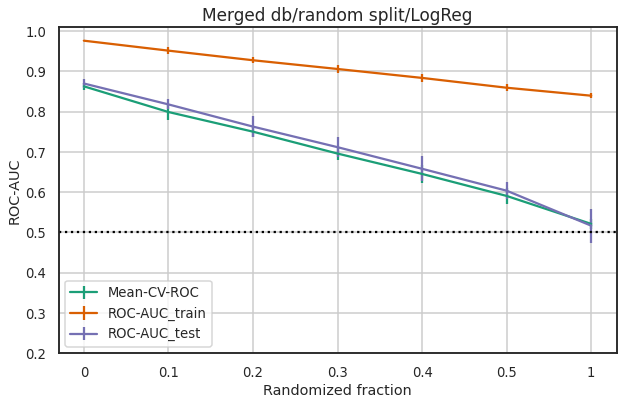

In [86]:
plot_results('Merged', 'LogReg', 'random')

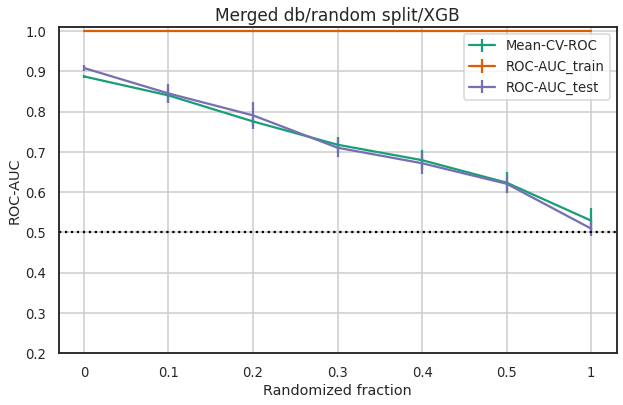

In [87]:
plot_results('Merged', 'XGB', 'random')

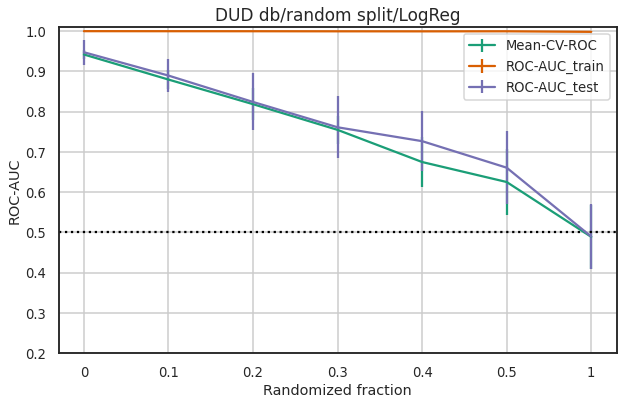

In [90]:
plot_results('DUD', 'LogReg', 'random')

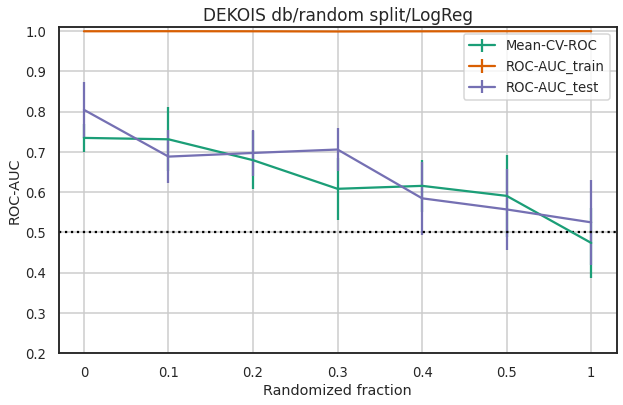

In [91]:
plot_results('DEKOIS', 'LogReg', 'random')

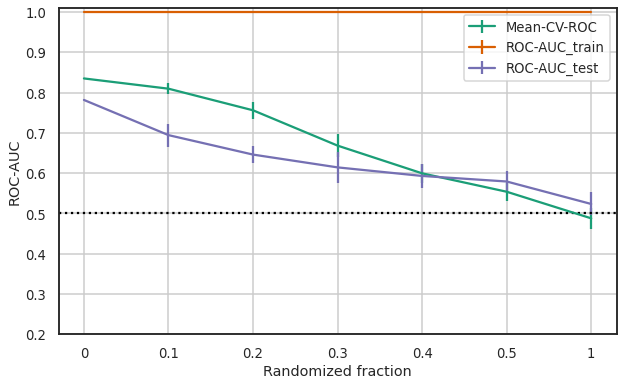

In [72]:
plot_results('Merged', 'XGB', 'scaffold')